loading data to a dataframe

In [1]:
import pandas as pd
import numpy as np

In [2]:
file_path = "raw_data/merged_data.csv"

In [3]:
df = pd.read_csv(file_path, sep='|', low_memory=False)

In [4]:
df_cleaned = df.drop_duplicates()
df_cleaned.reset_index(drop=True, inplace=True)

drop_cols = ['uid', 'history', 'tunnel_parents', 'detailed-label', 'local_resp', 'local_orig', 'missed_bytes']
df_cleaned.drop(columns=drop_cols, inplace=True, errors='ignore')

df_cleaned.dropna(subset=['label', 'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes'], inplace=True)

for col in ['duration', 'orig_bytes', 'resp_bytes']:
    df_cleaned[col] = df_cleaned[col].replace('-', np.nan)  # Replace '-' with NaN
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')  # Convert to numeric
    df_cleaned[col].fillna(0, inplace=True)

/var/folders/wx/l8wg57xn4zg_6jvfv7d2rly40000gn/T/ipykernel_57300/629937412.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned[col].fillna(0, inplace=True)


In [5]:
df_cleaned = df_cleaned.drop_duplicates()
df_cleaned.reset_index(drop=True, inplace=True)

In [6]:
columns = list(df_cleaned.columns)
zero_ratios = {col: (df_cleaned[col] == 0).mean() for col in columns}

for col, ratio in zero_ratios.items():
    print(f"{col}: {ratio:.2%} zeros")

ts: 0.00% zeros
id.orig_h: 0.00% zeros
id.orig_p: 0.00% zeros
id.resp_h: 0.00% zeros
id.resp_p: 0.03% zeros
proto: 0.00% zeros
service: 0.00% zeros
duration: 61.06% zeros
orig_bytes: 99.52% zeros
resp_bytes: 99.86% zeros
conn_state: 0.00% zeros
orig_pkts: 14.37% zeros
orig_ip_bytes: 14.37% zeros
resp_pkts: 99.78% zeros
resp_ip_bytes: 99.78% zeros
label: 0.00% zeros


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:>

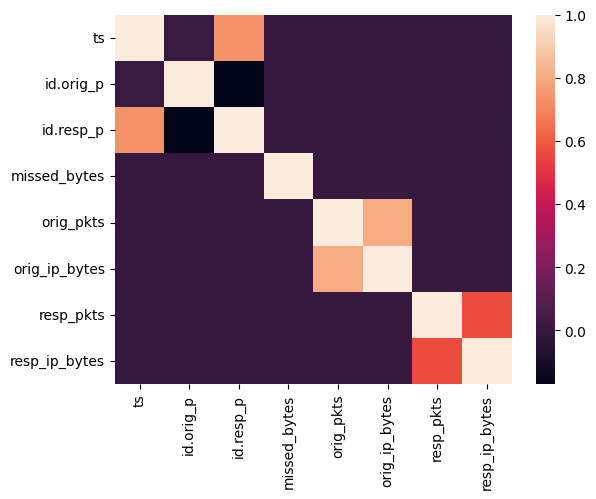

In [8]:
sns.heatmap(df.corr(numeric_only=True))

___________START JAD + KAWTAR______________________

In [9]:
df_clean = df_cleaned

______________

In [10]:
# Check number of unique values for each categorical feature in df_clean
categorical_features = ['proto', 'conn_state']
for col in categorical_features:
    unique_count = df_clean[col].nunique()
    print(f"{col}: {unique_count} unique values")

proto: 3 unique values
conn_state: 13 unique values


In [11]:
# Calculate and display the percentage of each unique value for each categorical feature in df_clean
categorical_features = ['proto', 'conn_state']
for col in categorical_features:
    print(f"\nValue percentages for '{col}':")
    value_counts = df_clean[col].value_counts(normalize=True) * 100
    print(value_counts.round(2).to_string())


Value percentages for 'proto':
proto
tcp     98.13
udp      1.77
icmp     0.10

Value percentages for 'conn_state':
conn_state
S0        76.57
OTH       14.73
RSTOS0     8.48
SF         0.13
REJ        0.06
S3         0.01
RSTR       0.01
RSTO       0.00
S2         0.00
S1         0.00
SH         0.00
RSTRH      0.00
SHR        0.00


In [12]:
# # Filter df_clean to keep only desired conn_state and history values
# df_clean = df_clean[df_clean['conn_state'].isin(['S0', 'RSTOS0'])]
# df_clean = df_clean[df_clean['history'].isin(['S', 'I'])]

# # Reset index after filtering
# df_clean = df_clean.reset_index(drop=True)

# df_clean['conn_state'].value_counts(), df_clean['history'].value_counts()

In [13]:
df_clean['label'] = df_clean['label'].apply(lambda x: 0 if x == 'Benign' else 1)

In [14]:
df_clean.drop(['id.orig_p', 'id.resp_p'], axis=1, inplace=True)

In [16]:
X = df_clean.drop('label', axis=1)
y = df_clean['label']

In [17]:
from sklearn.model_selection import train_test_split

In [18]:

# Split the data (70-30 split, stratified to maintain class distribution)
print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,  # Stratify to maintain class distribution
    random_state=42,
)

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Verify stratification worked
print("\nTrain set class distribution:")
print(y_train.value_counts())
print(f"Train malicious ratio: {(y_train.sum() / len(y_train) * 100):.2f}%")

print("\nTest set class distribution:")
print(y_test.value_counts())
print(f"Test malicious ratio: {(y_test.sum() / len(y_test) * 100):.2f}%")

Splitting data into train and test sets...

Train set: (17507702, 13)
Test set: (7503301, 13)

Train set class distribution:
label
1    11361591
0     6146111
Name: count, dtype: int64
Train malicious ratio: 64.89%

Test set class distribution:
label
1    4869254
0    2634047
Name: count, dtype: int64
Test malicious ratio: 64.89%


In [19]:
from sklearn.preprocessing import OneHotEncoder

# Select categorical columns to encode
categorical_cols = ['proto', 'conn_state']

# Fit OneHotEncoder on the categorical columns using X_train
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Fit and transform on X_train
encoded_train = encoder.fit_transform(X_train[categorical_cols])

# Only transform X_test
encoded_test = encoder.transform(X_test[categorical_cols])

# Get new column names
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)

# Create DataFrames for encoded features
encoded_train_df = pd.DataFrame(encoded_train, columns=encoded_feature_names, index=X_train.index)
encoded_test_df = pd.DataFrame(encoded_test, columns=encoded_feature_names, index=X_test.index)

/Users/jadlahrichi/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [20]:
encoded_train_df.head()

,proto_icmp,proto_tcp,proto_udp,conn_state_OTH,conn_state_REJ,conn_state_RSTO,conn_state_RSTOS0,conn_state_RSTR,conn_state_RSTRH,conn_state_S0,conn_state_S1,conn_state_S2,conn_state_S3,conn_state_SF,conn_state_SH,conn_state_SHR
23215231,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
738818,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1304284,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
13520024,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8024960,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
df_clean.head(2)

,ts,id.orig_h,id.resp_h,proto,service,duration,orig_bytes,resp_bytes,conn_state,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
0,1.545403e+09,192.168.1.196,104.248.160.24,tcp,-,3.097754,0.0,0.0,S0,3.0,180.0,0.0,0.0,1
1,1.545403e+09,192.168.1.196,104.248.160.24,tcp,-,0.000000,0.0,0.0,S0,1.0,60.0,0.0,0.0,1


In [22]:
from sklearn.preprocessing import RobustScaler, StandardScaler
# Let's first check for outliers in a few features
print("Checking for outliers in key features:")
# Select only numerical features for scaling
features_to_check = X_train.select_dtypes(include=[np.number]).columns.tolist()
for feat in features_to_check:
    if feat in X_train.columns:
        col_idx = X_train.columns.get_loc(feat)
        q1 = np.percentile(X_train.iloc[:, col_idx], 25)
        q3 = np.percentile(X_train.iloc[:, col_idx], 75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = ((X_train.iloc[:, col_idx] < lower_bound) | (X_train.iloc[:, col_idx] > upper_bound)).sum()
        print(f"{feat}: {outliers:,} outliers ({outliers/len(X_train)*100:.2f}%)")

# Use RobustScaler instead
# print("\nScaling features with RobustScaler...")
# scaler = RobustScaler()
scaler = StandardScaler()
# Fit on training data and transform
X_train_scaled_num = scaler.fit_transform(X_train[features_to_check])

# Transform test data
X_test_scaled_num = scaler.transform(X_test[features_to_check])

print("\nScaling complete!")
print(f"Scaled train shape: {X_train_scaled_num.shape}")
print(f"Scaled test shape: {X_test_scaled_num.shape}")

Checking for outliers in key features:
ts: 0 outliers (0.00%)
duration: 57,436 outliers (0.33%)
orig_bytes: 83,857 outliers (0.48%)
resp_bytes: 24,962 outliers (0.14%)
orig_pkts: 126,181 outliers (0.72%)
orig_ip_bytes: 65,137 outliers (0.37%)
resp_pkts: 37,926 outliers (0.22%)
resp_ip_bytes: 37,926 outliers (0.22%)

Scaling complete!
Scaled train shape: (17507702, 8)
Scaled test shape: (7503301, 8)


In [23]:
df_X_train_scaled_num = pd.DataFrame(X_train_scaled_num, columns=features_to_check, index=X_train.index)
df_X_test_scaled_num = pd.DataFrame(X_test_scaled_num, columns=features_to_check, index=X_test.index)

In [24]:
df_X_train_scaled_num.shape

(17507702, 8)

In [25]:
encoded_train_df.shape

(17507702, 16)

In [26]:
# Concatenate scaled numerical features and encoded categorical features for train and test sets

X_train_scaled = pd.concat([df_X_train_scaled_num, encoded_train_df], axis=1)
X_test_scaled = pd.concat([df_X_test_scaled_num, encoded_test_df], axis=1)

# Check the shapes to confirm concatenation
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

X_train_scaled shape: (17507702, 24)
X_test_scaled shape: (7503301, 24)


In [27]:
X_train_scaled.head(2)

,ts,duration,orig_bytes,resp_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,proto_icmp,proto_tcp,...,conn_state_RSTOS0,conn_state_RSTR,conn_state_RSTRH,conn_state_S0,conn_state_S1,conn_state_S2,conn_state_S3,conn_state_SF,conn_state_SH,conn_state_SHR
23215231,0.496055,-0.030971,-0.050217,-0.000253,-0.000801,-0.000732,-0.003488,-0.004637,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
738818,-0.002388,-0.030971,-0.050217,-0.000253,-0.000876,-0.000821,-0.003488,-0.004637,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier

# def perform_grid_search(model, param_grid, X_train, y_train, cv=3, scoring='accuracy'):
#     """
#     Performs grid search to find the best hyperparameters for a given model.

#     Args:
#         model: The machine learning model to tune.
#         param_grid: Dictionary with parameters names (string) as keys and lists of
#                     parameter settings to try as values.
#         X_train: Training feature matrix.
#         y_train: Training target vector.
#         cv (int): Number of cross-validation folds.
#         scoring (str): A single string to evaluate the predictions on the test set.

#     Returns:
#         The best estimator found by the grid search.
#     """
#     print(f"Performing GridSearchCV for {model.__class__.__name__}...")
#     print(f"Parameter grid: {param_grid}")
#     print(f"Scoring metric: {scoring}")
#     print(f"CV folds: {cv}\n")

#     # Create the GridSearchCV object
#     grid_search = GridSearchCV(
#         estimator=model,
#         param_grid=param_grid,
#         scoring=scoring,
#         cv=cv,
#         n_jobs=-1,  # Use all available cores
#         verbose=2
#     )

#     # Fit the grid search to the data
#     grid_search.fit(X_train, y_train)

#     # Print the best parameters and best score
#     print("\nGridSearchCV complete.")
#     print(f"Best {scoring} score: {grid_search.best_score_:.4f}")
#     print(f"Best parameters: {grid_search.best_params_}")

#     # Return the best estimator
#     return grid_search.best_estimator_

# # # --- 1. Logistic Regression ---
# # print("--- Grid Search for Logistic Regression ---")
# # lr = LogisticRegression(random_state=42)
# # param_grid_lr = {
# #     'C': [0.1, 1.0, 10],
# #     'solver': ['saga'], # saga is often good for large datasets
# #     'penalty': ['l1', 'l2']
# # }
# # best_lr_model = perform_grid_search(lr, param_grid_lr, X_train_scaled, y_train)


# # --- 2. Random Forest Classifier ---
# print("\n--- Grid Search for Random Forest Classifier ---")
# rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
# # Use a small grid for demonstration purposes
# param_grid_rfc = {
#     'n_estimators': [50, 100],       # Number of trees
#     'max_depth': [10, 20, None],     # Max depth of trees
#     'min_samples_leaf': [1, 5]       # Min samples in a leaf node
# }
# best_rfc_model = perform_grid_search(rfc, param_grid_rfc, X_train_scaled, y_train)

In [29]:
import time
import itertools
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

def perform_grid_search(model, param_grid, X_train, y_train, cv=3, scoring='accuracy'):
    """Performs GridSearchCV and returns the best estimator"""
    print(f"\n🔍 Grid Search for {model.__class__.__name__} with params: {param_grid}")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        n_jobs=4,
        verbose=1
    )
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    duration = time.time() - start_time
    print(f"✅ Done in {duration:.2f}s")
    print(f"Best score: {grid_search.best_score_:.4f}")
    print(f"Best params: {grid_search.best_params_}\n")
    return grid_search.best_estimator_, duration

def run_rf_grid_search(X_train, y_train, param_grid_steps, cv=3, scoring='accuracy'):
    results = []
    total_configs = sum(
        len(p['n_estimators']) * len(p['max_depth']) * len(p['min_samples_leaf'])
        for p in param_grid_steps
    )
    progress_bar = tqdm(total=total_configs, desc="🧪 Total Grid Search Progress", ncols=100)

    for step_i, param_grid in enumerate(param_grid_steps):
        combinations = list(itertools.product(
            param_grid['n_estimators'],
            param_grid['max_depth'],
            param_grid['min_samples_leaf']
        ))

        for est, depth, leaf in combinations:
            this_grid = {
                'n_estimators': [est],
                'max_depth': [depth],
                'min_samples_leaf': [leaf]
            }
            model = RandomForestClassifier(random_state=42, n_jobs=6)
            print(f"\n▶️ Step {step_i+1} | Grid: {this_grid}")
            best_model, duration = perform_grid_search(model, this_grid, X_train, y_train, cv=cv, scoring=scoring)
            results.append({
                'params': this_grid,
                'best_model': best_model,
                'duration_sec': duration
            })
            progress_bar.update(1)

    progress_bar.close()
    return results

In [30]:
param_grid_steps = [
    {'n_estimators': [50],     'max_depth': [10],      'min_samples_leaf': [1]},
    {'n_estimators': [50],     'max_depth': [10, 20],  'min_samples_leaf': [1, 5]},
    {'n_estimators': [50,100], 'max_depth': [10, 20],  'min_samples_leaf': [1, 5]},
    {'n_estimators': [50,100], 'max_depth': [10, 20, None], 'min_samples_leaf': [1, 3, 5]}
]

In [31]:
from sklearn.ensemble import RandomForestClassifier

base_model = RandomForestClassifier(random_state=42, n_jobs=4)

In [32]:
rf_results = run_rf_grid_search(
    X_train_scaled, y_train,
    param_grid_steps=param_grid_steps,
    cv=3,
    scoring='accuracy'
)

🧪 Total Grid Search Progress:   0%|                                         | 0/31 [00:00<?, ?it/s]


▶️ Step 1 | Grid: {'n_estimators': [50], 'max_depth': [10], 'min_samples_leaf': [1]}

🔍 Grid Search for RandomForestClassifier with params: {'n_estimators': [50], 'max_depth': [10], 'min_samples_leaf': [1]}
Fitting 3 folds for each of 1 candidates, totalling 3 fits


🧪 Total Grid Search Progress:   3%|▉                             | 1/31 [10:52<5:26:04, 652.14s/it]

✅ Done in 652.13s
Best score: 0.9979
Best params: {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 50}


▶️ Step 2 | Grid: {'n_estimators': [50], 'max_depth': [10], 'min_samples_leaf': [1]}

🔍 Grid Search for RandomForestClassifier with params: {'n_estimators': [50], 'max_depth': [10], 'min_samples_leaf': [1]}
Fitting 3 folds for each of 1 candidates, totalling 3 fits


🧪 Total Grid Search Progress:   6%|█▉                            | 2/31 [21:12<5:06:03, 633.23s/it]

✅ Done in 619.99s
Best score: 0.9979
Best params: {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 50}


▶️ Step 2 | Grid: {'n_estimators': [50], 'max_depth': [10], 'min_samples_leaf': [5]}

🔍 Grid Search for RandomForestClassifier with params: {'n_estimators': [50], 'max_depth': [10], 'min_samples_leaf': [5]}
Fitting 3 folds for each of 1 candidates, totalling 3 fits


🧪 Total Grid Search Progress:  10%|██▉                           | 3/31 [31:01<4:46:07, 613.12s/it]

✅ Done in 589.17s
Best score: 0.9979
Best params: {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 50}


▶️ Step 2 | Grid: {'n_estimators': [50], 'max_depth': [20], 'min_samples_leaf': [1]}

🔍 Grid Search for RandomForestClassifier with params: {'n_estimators': [50], 'max_depth': [20], 'min_samples_leaf': [1]}
Fitting 3 folds for each of 1 candidates, totalling 3 fits


🧪 Total Grid Search Progress:  13%|███▊                          | 4/31 [44:55<5:15:09, 700.35s/it]

✅ Done in 834.08s
Best score: 0.9980
Best params: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 50}


▶️ Step 2 | Grid: {'n_estimators': [50], 'max_depth': [20], 'min_samples_leaf': [5]}

🔍 Grid Search for RandomForestClassifier with params: {'n_estimators': [50], 'max_depth': [20], 'min_samples_leaf': [5]}
Fitting 3 folds for each of 1 candidates, totalling 3 fits


KeyboardInterrupt: 

In [ ]:
import pandas as pd

# On extrait les infos utiles (paramètres et durée)
rf_results_df = pd.DataFrame([
    {
        'n_estimators': list(r['params']['n_estimators'])[0],
        'max_depth': list(r['params']['max_depth'])[0],
        'min_samples_leaf': list(r['params']['min_samples_leaf'])[0],
        'duration_sec': round(r['duration_sec'], 2)
    }
    for r in rf_results
])

# Sauvegarde dans un fichier CSV
rf_results_df.to_csv("rf_grid_results.csv", index=False)

print("📁 Résultats exportés dans rf_grid_results.csv")

In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import cross_validate

# print("Performing 5-fold cross-validation...")
# print("This will take a while with 7.8M samples...\n")

# # Define scoring metrics
# scoring = {
#     'accuracy': 'accuracy',
#     'precision': 'precision',
#     'recall': 'recall',
#     'f1': 'f1'
# }

# # Train Logistic Regression
# print("Training Logistic Regression model...")
# lr_model = LogisticRegression(
# )

# # Perform cross-validation
# cv_results = cross_validate(
#     lr_model,
#     X_train_scaled,
#     y_train,
#     cv=5,  # 5-fold CV
#     scoring=scoring,
#     n_jobs=-1,  # Parallel processing
#     verbose=1,
#     return_train_score=True
# )

# # Display results
# print("\n=== CROSS-VALIDATION RESULTS (5-FOLD) ===")
# for metric in scoring.keys():
#     train_scores = cv_results[f'train_{metric}']
#     val_scores = cv_results[f'test_{metric}']

#     print(f"\n{metric.upper()}:")
#     print(f"  Train: {train_scores.mean():.4f} (+/- {train_scores.std() * 2:.4f})")
#     print(f"  Val:   {val_scores.mean():.4f} (+/- {val_scores.std() * 2:.4f})")
#     print(f"  Gap:   {abs(train_scores.mean() - val_scores.mean()):.4f}")


In [ ]:
# df_clean.head(10)

In [ ]:
# from sklearn.ensemble import RandomForestClassifier

In [ ]:
# clf = RandomForestClassifier(
#     n_estimators=100,
#     random_state=42,
#     n_jobs=-1)

# clf.fit(X_train_scaled, y_train)

In [ ]:
# from sklearn.metrics import classification_report, accuracy_score


In [ ]:
# y_pred = clf.predict(X_test_scaled)
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))

In [2]:
# Load the saved model
import pickle
with open("flowguard_logreg_model.pkl", "rb") as file:
    loaded_model = pickle.load(file)
# Test the loaded model
print(":white_check_mark: Loaded model accuracy:", loaded_model.score(X_test_scaled, y_test))

NameError: name 'X_test_scaled' is not defined